# 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져보자

### Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

필요한 라이브러리 임포트하기

In [59]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
# news_summary_more.csv 데이터 다운받아서 사용하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [61]:
data = data[['headlines','text']]
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [62]:
# 무작위로 데이터샘플 10개 추출
data.sample(10) 

,headlines,text
80585,Australia plans law to force tech giants to de...,Australia has unveiled a new legislation which...
59786,Commercial cinema actresses taken for granted:...,Actress Jacqueline Fernandez has said that she...
68777,"Indians like watches with big dials, many colo...","Tobias Reiss-Schmidt, President and CEO of wat..."
9893,Hackers find iPhone X bug accessing deleted pi...,Two hackers have earned a bounty of Ã¢ÂÂ¹35 l...
79687,"Bengaluru to be developed as hub for gaming, a...",To develop Bengaluru as the international hub ...
62205,Aditya summoned by ED in Ã¢ÂÂ¹1000 cr music r...,"Filmmaker Aditya Chopra, Sony Music India Vice..."
62600,Pakistan media blames India for cross-border p...,A report published in Pakistan's Dawn newspape...
93182,Turkey favours expanding Prez powers with 75% ...,Votes in favour of Turkish constitutional chan...
19247,"T'gana cop caught on camera beating up wife, m...",A policeman in Telangana was caught on camera ...
5552,Best I could do: Lata on recording played at A...,"Lata Mangeshkar, who recorded a rendition of t..."


데이터 확인해보니 헤드라인과 텍스트 두가지 열로 구성 되어있음

### Step 2. 데이터 전처리하기 (추상적 요약)

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습 할 수 있다

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

**(1) 데이터 정리하기**

데이터를 불러왔으니 전처리를 진행해 볼게요. 

빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.

In [63]:
# 데이터의 중복 샘플 유무를 확인

print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [64]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거
data.drop_duplicates(subset = ['headlines'], inplace=True)
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿔준다

print('전체 샘플수 :', (len(data))) 

전체 샘플수 : 98280


In [65]:
# .isnull().sum()을 사용하여 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum()) # 기사 헤드라인에 null값이 있을수가 있나?

headlines    0
text         0
dtype: int64


In [66]:
# 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용하면 돼요.
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


아무래도 기사 헤드라인이다 보니까 null값이 있을수 없는거 같음 그러니 아마도 위에 두 코드는 사용하지 않아도 될거같다

텍스트 정규화와 불용어 제거

In [67]:
# 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [68]:
# NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [69]:
# 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 
# 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 
# 짧은 Summary 전처리할 때는 호출하지 않을 예정
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [70]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출
temp_headlines = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_text = 'Great way to start (or finish) the day!!!'

In [71]:
print("headlines: ", preprocess_sentence(temp_headlines))
print("text:", preprocess_sentence(temp_text, False))  # 불용어를 제거하지 않습니다.

headlines:  everything bought great infact ordered twice third ordered wasfor mother father
text: great way to start the day


In [72]:
# 훈련 데이터 전체에 대해서 전처리를 수행

# headlines의 경우에는 불용어를 제거한다
clean_headlines = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [73]:
# text에 대해서 전처리 함수를 호출해 줄 때는, 
# 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요
clean_text = []
# 전체 text 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s, False))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their sevent

In [74]:
# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장
data['headlines'] = clean_headlines
data['text'] = clean_text

In [75]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [76]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인
data.isnull().sum() # 역시나 null값은 없음 무의미 해보이나 일단 배운것이기 때문에 해보았음

headlines    0
text         0
dtype: int64

In [77]:
# 데이터프레임에서 null제거 하기
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data))) # 제거된 null값 존재하지 않음

전체 샘플수 : 98280


**(2) 훈련데이터와 테스트데이터 나누기**

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.1367317867317865
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.18174603174603


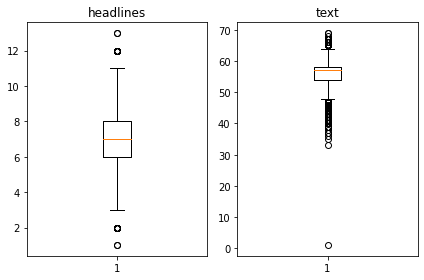

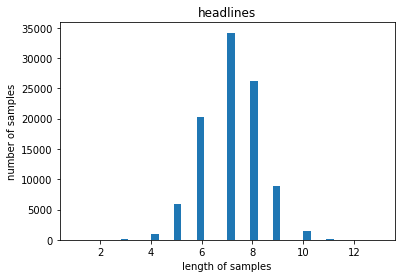

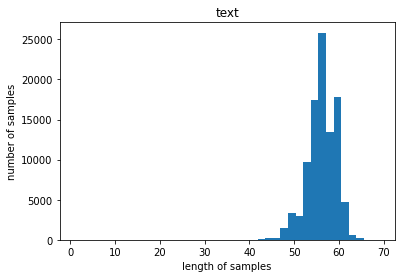

In [78]:
# headlines와 text의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show() # 실제 헤드라인과 텍스트의 길이 분포

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show() # 실제 헤드라인 샘플 길이별 개수

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show() # 텍스트본 샘플 길이별 개수

위에 표를 보고 적절한 길이를 정해보았음

In [82]:
# headlines의 최대 길이와 text의 적절한 최대 길이를 임의로 정해보자
headlines_max_len = 7
text_max_len = 57

In [83]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보기
# 전체 샘플 중에서 길이가 max_len 이하인 샘플 비율이 몇 %인지 확인 함수 작성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [84]:
# headlines와 text에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.6263634513634514
전체 샘플 중 길이가 57 이하인 샘플의 비율: 0.6256206756206756


In [85]:
# 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 39872


In [86]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
# 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞뒤로 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
6,india get lowest odi total new zealand,india recorded their lowest odi total in new z...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
12,ram krishna smoke ramdev sadhus kumbh,urging saints and seers at the kumbh mela to q...,sostoken ram krishna smoke ramdev sadhus kumbh,ram krishna smoke ramdev sadhus kumbh eostoken
18,long tolerate congress leaders potshots taka cm,days after he threatened to step down from his...,sostoken long tolerate congress leaders potsho...,long tolerate congress leaders potshots taka c...
20,think opposition even dreams pm modi,claiming there is dearth of ideas among opposi...,sostoken think opposition even dreams pm modi,think opposition even dreams pm modi eostoken
22,killed injured saudi arabia floods,at least people have been killed and others ha...,sostoken killed injured saudi arabia floods,killed injured saudi arabia floods eostoken


In [87]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


훈련 데이터와 테스트 데이터를 분리

In [88]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[14166 18457 28012 ... 20033 17168  6245]


In [89]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [90]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 7974


In [91]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의
encoder_input_train = encoder_input[:-n_of_val] # 뒤에서 n_of_val 번째 제외
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 31898
훈련 레이블의 개수 : 31898
테스트 데이터의 개수 : 7974
테스트 레이블의 개수 : 7974


**(3) 정수 인코딩**

**단어 집합(vocabulary) 만들기 및 정수 인코딩**

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 

이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현

In [92]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합 만들수 있음
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [93]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 
# 이를 통해서 통계적인 정보를 얻을 수 있어요.
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47869
등장 빈도가 5번 이하인 희귀 단어의 수: 32455
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15414
단어 집합에서 희귀 단어의 비율: 67.79961979569241
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.526808239121552


In [94]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 
# 훈련 데이터에서 제거하고자 합니다. 
# 위에서 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 
# 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20000으로 제한해볼게요. 
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [95]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 
# 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 
# 현재 단어 집합의 크기를 20000으로 제한했으니까 
# 이제 20000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3]) # 텍스트 데이터가 아니라 정수가 나옴

[[238, 186, 438, 215, 7, 5293, 1, 499, 28, 688, 179, 2, 1017, 8, 102, 41, 13, 46, 560, 1480, 83, 2644, 5188, 1, 75, 39, 142, 3, 3645, 311, 10, 1, 519, 213, 2861, 191, 24, 2706, 76, 2170, 213, 215, 19, 39, 1323, 1, 10055, 213, 5, 925, 651, 1809, 16, 1358, 1347], [3027, 3646, 30, 11, 31, 172, 4, 32, 462, 1470, 1324, 822, 3, 318, 4, 221, 12971, 1584, 3, 1, 463, 970, 4, 1, 305, 170, 49, 267, 793, 6, 151, 1, 1337, 28, 314, 84, 1367, 3, 491, 72, 33, 990, 12051, 2, 1021, 822, 3646, 26, 31, 1324, 822, 8, 32, 3, 1126, 153, 372], [18, 228, 18, 976, 666, 4, 32, 289, 904, 726, 450, 3, 1059, 19, 4280, 1150, 5, 268, 18, 12972, 17, 757, 407, 58, 5189, 5920, 38, 33, 8, 38, 1359, 1, 60, 11259, 306, 7, 9555, 14, 1, 2707, 11260, 737, 10, 1733, 8, 1, 1965, 4, 976, 666, 3, 1, 60]]


In [96]:
# decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [97]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 20920
등장 빈도가 4번 이하인 희귀 단어의 수: 14207
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6713
단어 집합에서 희귀 단어의 비율: 67.9110898661568
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.265685630075698


In [98]:
tar_vocab = 6000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])
# 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 
# 더 이상 숫자 6000이 넘는 숫자들은 존재하지 않아요

input
input  [[1, 61, 4357, 108, 328, 375], [1, 2433, 762, 1828, 2199, 654, 1906, 58], [1, 763, 247, 329, 159, 2434, 3031], [1, 792, 445, 622, 3], [1, 4757, 4758, 496, 1311, 602, 2087]]
target
decoder  [[61, 4357, 108, 328, 375, 2], [2433, 762, 1828, 2199, 654, 1906, 58, 2], [763, 247, 329, 159, 2434, 3031, 2], [792, 445, 622, 3, 2], [4757, 4758, 496, 1311, 602, 2087, 2]]


In [99]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 
# 이 샘플들은 모두 삭제할 거예요.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
# 훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인

삭제할 훈련 데이터의 개수 : 6
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 31892
훈련 레이블의 개수 : 31892
테스트 데이터의 개수 : 7973
테스트 레이블의 개수 : 7973


패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [100]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


모델 설계하기

In [101]:
# 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
# hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
# LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다. 크다고 성능 좋아지는거 아님
# hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘리는 것
embedding_dim = 128 # 임베딩 벡터 차원 128로 정의
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1 # 3개의 층으로 복잡도 높힌다는 것은 모델의 용량을 늘린다
# LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용해요. 
# 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결
# recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식
# time step의 입력을 랜덤으로 생략해 주는 거죠. 
#recurrent dropout은 regularization을 해주는 효과가 있고, 과적합을 방지
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [102]:
# 디코더를 설계
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# LSTM의 입력을 정의할 때, initial_state의 인자값으로 
# 인코더의 hidden state와 cell state의 값을 넣어줘야 함

In [103]:
# 디코더의 출력층을 설계
# 디코더의 출력층
# tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
# 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 57, 128)      1920000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 57, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

**어텐션 메커니즘**

디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻

참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션

In [104]:
# 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 위의 코드는 인코더의 hidden state와 디코더의 hidden state를 어텐션 함수의 입력으로 사용
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 57, 128)      1920000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 57, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

모델 훈련하기

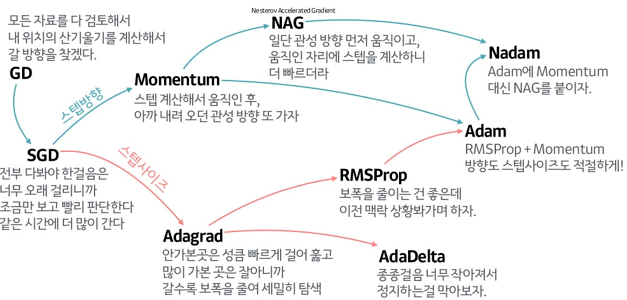

In [105]:
# 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)
# EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할

Epoch 1/50
125/125 [==============================] - 101s 751ms/step - loss: 6.4734 - val_loss: 6.0901
Epoch 2/50
125/125 [==============================] - 92s 739ms/step - loss: 6.1215 - val_loss: 5.9254
Epoch 3/50
125/125 [==============================] - 92s 739ms/step - loss: 5.9060 - val_loss: 5.7481
Epoch 4/50
125/125 [==============================] - 93s 747ms/step - loss: 5.7492 - val_loss: 5.6602
Epoch 5/50
125/125 [==============================] - 93s 745ms/step - loss: 5.5883 - val_loss: 5.5345
Epoch 6/50
125/125 [==============================] - 93s 745ms/step - loss: 5.4133 - val_loss: 5.3795
Epoch 7/50
125/125 [==============================] - 93s 740ms/step - loss: 5.2420 - val_loss: 5.2615
Epoch 8/50
125/125 [==============================] - 91s 730ms/step - loss: 5.0715 - val_loss: 5.1514
Epoch 9/50
125/125 [==============================] - 92s 733ms/step - loss: 4.9206 - val_loss: 5.0846
Epoch 10/50
125/125 [==============================] - 91s 732ms/step - 

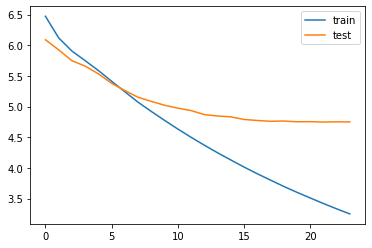

In [106]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

인퍼런스 모델 구현하기

In [107]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
# 해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [108]:
# seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 
# 그에 맞게 모델 설계를 별개로 진행해야 한다는 것

# 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 
# 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비

# 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 
# 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 
# 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [109]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [110]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어보자
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

모델 테스트하기

함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [111]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는것이 편하다
def seq2text(input_seq): # Text의 정수 시퀸스에서는 패딩을 위해 사용되는 숫자 0을 제외
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들어 보기
def seq2headlines(input_seq): 
# headlines의 정수 시퀸스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외
    temp=''
    for i in input_seq: 
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [113]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    
# 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과

# 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고,
#  빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 
# 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 
# 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것

원문 : virender sehwag was captaining india when he hit runs against windies on december becoming the second cricketer after sachin tendulkar to score double hundred in odis sehwag is the highest individual score by captain in odi cricket history sehwag knock helped india pile up their highest odi total of 
실제 요약 : sehwag highest score captain odis 
예측 요약 :  sehwag hit sachin sehwag


원문 : reacting to england alastair cook announcing his retirement shahid afridi tweeted cook you are true great of the game all the very best in your life after cricket trust me so much less pressure wonderful player who was wonderful ambassador of the game afridi wrote about the former england test captain 
실제 요약 : trust much less pressure afridi retiring cook 
예측 요약 :  gavaskar tweets user


원문 : the national investigation agency has registered case in connection with the killing of rss leader in ludhiana was murdered by two unidentified bike borne assailants last month while returning home from drill punj

추상적 요약을 했을때 예측 요약과 실제 요약이 비슷한것도 있지만 차이 나는 것도 많이 있는거 같음 요약만 가지고 원문을 예측하기 어려워 보인다. 그리고 예측 요약을 짧게 해주는 경향이 있음

### Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

패키지 설치하기

In [ ]:
pip list | grep summa

In [ ]:
# 데이터 다운로드하기

import requests
from summa.summarizer import summarize

news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
news["text"]

In [ ]:
# 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인
print(news[:1500])

summarize 사용하기

In [ ]:
# Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 
# 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력
# print('headlines:')
# print(summarize(news, ratio=0.005))

print('headlines:')
print(summarize(news["text"][i], ratio=0.5)) # 텍스트에 인덱스 넘버를 줘서 불러오기

처음에 주석 처리 된 부분으로 실행하니까 ValueError: Text parameter must be a Unicode object (str)! 에러 뜸

print(summarize(news["text"][i], ratio=0.5)) 하니까 됨

ratio 0.005하니까 안뜨고 0.05해도 안뜨고 0.5하니까 뜸

In [ ]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.
print('headlines:')
print(summarize(news["text"][i], ratio=0.5, split=True))

In [ ]:
# 단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택 해보자
print('headlines:')
print(summarize(news["text"][i], words=50))

**회고**

단어집합에서 빈도수가 낮은 단어들을 제거한다고 한거 같은데 좀 더 잘라야 했을 필요가 있어 보인다. 하지만 한번 돌릴때마다 시간이 너무 오래걸려서 많이 시도해보지 못하였음. 그래서 그런가 추상적 요약이 된 문장을 보면 알아먹을수 없는 문장도 여럿 보이는것같다. 그리고 예측문장과 실제 문장이 조금 차이를 보이는 부분도 있는거같음. 추출적 요약은 조금은 더 완성된 문장으로 나오긴 하지만 추상적 요약 보다는 좀 긴 문장으로 나왔고 기사 헤드라인이라고 보면 조금 길지 않을까 하는 생각도 들기도 한다. max_len을 적절하게 정한다고 했는데 생각보다 더 했어야했는지 로스값이 너무 높게 나와서 새로 지정하니까 예측 요약이랑 실제 예측이랑 조금 더 비슷한거 같네요 
